# Deep learning-based automated rock classification via high-resolution drone-captured core sample imagery
***
### Domenico M. Crisafulli, Misael M. Morales, and Carlos Torres-Verdin
#### The University of Texas at Austin, 2024
***

## Build and Train NN-classifier
| Class             | OLD   | New   |
| ---               | ---   | ---   |
| Background        | 0     | 0     |
| Sandstone type 1  | 1     | 2     |
| Shaly Rock        | 2     | 3     |
| Sandstone type 2  | 3     | 4     |
| Carbonate         | 4     | 5     |
| Shale             | 5     | 6     |
| Sandstone type 3  | 6     | 7     |
| Box               | 10    | 1     |

In [1]:
import os
from time import time
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from tqdm import tqdm

from PIL import Image
import scipy.io as sio

import tensorflow as tf
import keras
import tf_keras as tfk
from keras import Model
from keras import layers, losses, optimizers, activations
from keras.applications.resnet import ResNet50, preprocess_input

def check_tf_gpu(verbose:bool=True):
    sys_info = tf.sysconfig.get_build_info()
    version, cuda, cudnn = tf.__version__, sys_info["cuda_version"], sys_info["cudnn_version"]
    count = len(tf.config.experimental.list_physical_devices())
    name  = [device.name for device in tf.config.experimental.list_physical_devices('GPU')]
    if verbose:
        print('-'*60)
        print('----------------------- VERSION INFO -----------------------')
        print('TF version: {} | # Device(s) available: {}'.format(version, count))
        print('TF Built with CUDA? {} | CUDA: {} | cuDNN: {}'.format(tf.test.is_built_with_cuda(), cuda, cudnn))
        print(tf.config.list_physical_devices()[0],'\n', tf.config.list_physical_devices()[1])
        print('-'*60+'\n')
    return None

check_tf_gpu()

2024-07-24 19:56:58.722867: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-24 19:56:58.733784: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-24 19:56:58.736974: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-24 19:56:58.744932: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-24 19:56:59.327038: W tensorflow/compiler/tf2

------------------------------------------------------------
----------------------- VERSION INFO -----------------------
TF version: 2.17.0 | # Device(s) available: 2
TF Built with CUDA? True | CUDA: 12.3 | cuDNN: 8
PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU') 
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
------------------------------------------------------------



I0000 00:00:1721869019.974130   11252 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1721869019.990971   11252 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1721869019.991012   11252 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [2]:
def patch_image(input_image, patch_h=252, patch_w=252, pad=4, channel_axis=-1):
    if channel_axis is not None:
        h, w, c = input_image.shape
    else:
        h, w = input_image.shape
    patches = []
    for i in range(0, h, patch_h):
        for j in range(0, w, patch_w):
            if channel_axis is not None:
                patch = input_image[i:i+patch_h, j:j+patch_w, :]
                patch = np.pad(patch, ((pad,pad),(pad,pad),(0,0)))
            else:
                patch = input_image[i:i+patch_h, j:j+patch_w]
                patch = np.pad(patch, ((pad,pad),(pad,pad)))
            patches.append(patch)
    return np.array(patches)

In [3]:
x_names_pictures = []
for root, dirs, files in os.walk('data'):
    for f in files:
        if (f.endswith('.jpg') or f.endswith('.JPG')) and f.startswith('DJI'):
            x_names_pictures.append(os.path.join(root, f))

y_names_masks = []
for root, dirs, files in os.walk('data'):
    for file in files:
        if file.endswith('.mat') and file.startswith('img_'):
            y_names_masks.append(os.path.join(root, file))

In [4]:
x_pictures = []
y_masks    = []
for i in tqdm(range(len(x_names_pictures)), desc='Loading images'):
    y = sio.loadmat(y_names_masks[i],simplify_cells=True)
    if 'AA' in y.keys():
        y_masks.append(y['AA'])
        x = np.array(Image.open(x_names_pictures[i]).convert('RGB'))
        x_pictures.append(x)

X_data = np.array(x_pictures)
y_data = np.array(y_masks)
print(X_data.shape, y_data.shape)

Loading images: 100%|██████████| 17/17 [00:16<00:00,  1.00it/s]


(15, 3024, 4032, 3) (15, 3024, 4032)


In [5]:
IMAGE_SIZE = 504
PADDING = 4
PADDED_IMAGE = IMAGE_SIZE+PADDING*2

x_data_patched = []
y_data_patched = []
for i in tqdm(range(X_data.shape[0]), desc='Patching images'):
    x = patch_image(X_data[i], patch_h=IMAGE_SIZE, patch_w=IMAGE_SIZE, pad=PADDING)
    x_data_patched.append(x)
    y = patch_image(y_data[i], patch_h=IMAGE_SIZE, patch_w=IMAGE_SIZE, pad=PADDING, channel_axis=None)
    y_data_patched.append(y)
    
x_data_patched = np.array(x_data_patched).reshape(-1, PADDED_IMAGE, PADDED_IMAGE, 3)
y_data_patched = np.array(y_data_patched).reshape(-1, PADDED_IMAGE, PADDED_IMAGE, 1)
print(x_data_patched.shape, y_data_patched.shape)

Patching images: 100%|██████████| 15/15 [00:00<00:00, 50.43it/s]


(720, 512, 512, 3) (720, 512, 512, 1)


In [6]:
idx = []
for i in tqdm(range(y_data_patched.shape[0]), desc='Nonzero Filter'):
    m = y_data_patched[i]
    p = np.sum(m)
    if p > 5e3:
        idx.append(i)

x_data_nonzero = x_data_patched[idx].astype(np.float32)
y_data_nonzero = y_data_patched[idx].astype(np.uint8)
print(x_data_nonzero.shape, y_data_nonzero.shape)

Nonzero Filter: 100%|██████████| 720/720 [00:00<00:00, 8794.58it/s]


(278, 512, 512, 3) (278, 512, 512, 1)


In [7]:
rand_idx = np.random.choice(x_data_nonzero.shape[0], size=x_data_nonzero.shape[0], replace=False)
n_train = 250

X_train = x_data_nonzero[rand_idx[:n_train]]/255
y_train = y_data_nonzero[rand_idx[:n_train]]

X_test = x_data_nonzero[rand_idx[n_train:]]/255
y_test = y_data_nonzero[rand_idx[n_train:]]

y_train[y_train==255] = 5
y_test[y_test==255] = 5

print('X - train: {} | test: {}'.format(X_train.shape, X_test.shape))
print('y - train: {} | test: {}'.format(y_train.shape, y_test.shape))
print('Labels - train: {} | test: {}'.format(np.unique(y_train), np.unique(y_test)))

X - train: (250, 512, 512, 3) | test: (28, 512, 512, 3)
y - train: (250, 512, 512, 1) | test: (28, 512, 512, 1)
Labels - train: [0 1 2 3 4 5 6] | test: [0 1 2 3 4 5 6]


In [8]:
nlabels = len(np.unique(y_train))

y_train_masked = np.zeros((y_train.shape[0], 512, 512, nlabels))
y_test_masked  = np.zeros((y_test.shape[0], 512, 512, nlabels))

for i in tqdm(range(nlabels), desc='One-Hot Encoding labels'):
    y_train_masked[...,i] = (y_train[...,0]==i).astype(np.uint8)
    y_test_masked[...,i]  = (y_test[...,0]==i).astype(np.uint8)
print('y masked - train: {} | test: {}'.format(y_train_masked.shape, y_test_masked.shape))

One-Hot Encoding labels: 100%|██████████| 7/7 [00:02<00:00,  2.50it/s]

y masked - train: (250, 512, 512, 7) | test: (28, 512, 512, 7)


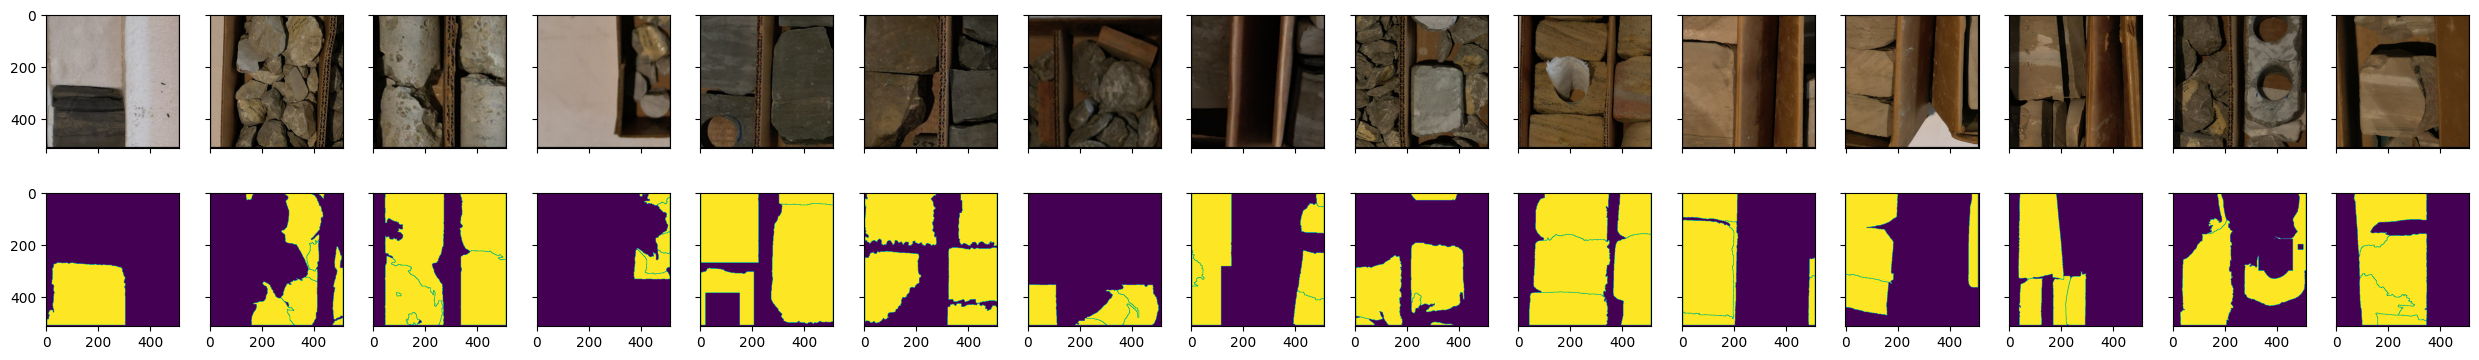

In [9]:
fig, axs = plt.subplots(2, 15, figsize=(25,4), sharex=True, sharey=True)
for j in range(15):
    ax1, ax2 = axs[0,j], axs[1,j]
    ax1.imshow(X_train[j])
    ax2.imshow(y_train[j])
plt.tight_layout()
plt.show()

In [10]:
class MonitorCallback(keras.callbacks.Callback):
    def __init__(self, monitor:int=10):
        super(MonitorCallback, self).__init__()
        self.monitor = monitor
    
    def on_epoch_end(self, epoch, logs=None):
        if (epoch+1) % self.monitor == 0:
            print('Epoch: {} | Accuracy: {:.3f} | Loss: {:.3e}'.format(epoch+1, logs['accuracy'], logs['loss']))

In [11]:
def CoreSegNet(image_size:int=512, in_channels:int=3, out_channels:int=1):
    
    def convolution_block(inp, num_filters, kernel_size=3, dropout=0.1):
        _ = layers.SeparableConv2D(num_filters, kernel_size=kernel_size, padding="same")(inp)
        _ = layers.GroupNormalization(num_filters)(_)
        _ = activations.gelu(_)
        _ = layers.SpatialDropout2D(dropout)(_)
        return _
    
    # Encoder
    input = layers.Input(shape=(image_size, image_size, in_channels))
    x = convolution_block(input, 16)
    x = layers.MaxPooling2D(2)(x)
    f1 = x
    x = convolution_block(x, 64)
    x = layers.MaxPooling2D(2)(x)
    f2 = x
    x = convolution_block(x, 256)
    x = layers.MaxPooling2D(2)(x)
    f3 = x
    
    # Decoder
    x = layers.concatenate([x, f3])
    x = convolution_block(x, 256)
    x = layers.Conv2DTranspose(64, 2, 2, padding='same')(x)

    x = layers.concatenate([x, f2])
    x = convolution_block(x, 64)
    x = layers.Conv2DTranspose(16, 2, 2, padding='same')(x)

    x = layers.concatenate([x, f1])
    x = convolution_block(x, 16)
    x = layers.Conv2DTranspose(out_channels, 2, 2, padding='same')(x)

    output = layers.Conv2D(out_channels, 1, 1, activation='softmax')(x)
    
    return Model(inputs=input, outputs=output)

In [12]:
def CustomLoss(true, pred, alpha=0.75):
    cce = losses.categorical_crossentropy(true, pred)
    ssim = tf.reduce_mean(1 - tf.image.ssim_multiscale(true, pred, max_val=1.0))
    return alpha*cce + (1-alpha)*ssim

In [13]:
model = CoreSegNet(image_size=512, out_channels=7)
print('# parameters: {:,}'.format(model.count_params())+'\n'+'-'*30)

optimizer = optimizers.AdamW(learning_rate=1e-3, weight_decay=1e-5)
criterion = losses.CategoricalCrossentropy()
callbacks = [MonitorCallback(monitor=10)]
model.compile(optimizer=optimizer, loss=criterion, metrics=['accuracy', 'mse'])

start = time()
fit = model.fit(X_train, y_train_masked,
                batch_size       = 8, 
                epochs           = 201, 
                validation_split = 0.2,
                shuffle          = True,
                verbose          = 0,
                callbacks        = [callbacks])
print('-'*30+'\n'+'Training time: {:.2f} minutes'.format((time()-start)/60))
model.save('CoreSegNet.keras')
pd.DataFrame(fit.history).to_csv('CoreSegNet_history.csv', index=False)

I0000 00:00:1721869045.604071   11252 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1721869045.604169   11252 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1721869045.604196   11252 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1721869045.848144   11252 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1721869045.848215   11252 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-24

# parameters: 236,266
------------------------------


2024-07-24 19:57:32.502388: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 629145600 exceeds 10% of free system memory.
2024-07-24 19:57:35.051849: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1468006400 exceeds 10% of free system memory.
2024-07-24 19:57:35.786928: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 629145600 exceeds 10% of free system memory.
2024-07-24 19:57:36.032510: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1468006400 exceeds 10% of free system memory.
2024-07-24 19:57:39.922685: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 58720256 exceeds 10% of free system memory.
I0000 00:00:1721869060.129008   11571 service.cc:146] XLA service 0x7f9070223a00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1721869060.129054   11571 service.cc:154]   StreamExecutor device (0): NVIDIA 

Epoch: 10 | Accuracy: 0.655 | Loss: 9.104e-01
Epoch: 20 | Accuracy: 0.691 | Loss: 7.682e-01
Epoch: 30 | Accuracy: 0.756 | Loss: 6.339e-01
Epoch: 40 | Accuracy: 0.856 | Loss: 4.655e-01
Epoch: 50 | Accuracy: 0.849 | Loss: 4.534e-01
Epoch: 60 | Accuracy: 0.922 | Loss: 2.418e-01
Epoch: 70 | Accuracy: 0.937 | Loss: 1.883e-01
Epoch: 80 | Accuracy: 0.940 | Loss: 1.736e-01
Epoch: 90 | Accuracy: 0.951 | Loss: 1.401e-01
Epoch: 100 | Accuracy: 0.959 | Loss: 1.167e-01
Epoch: 110 | Accuracy: 0.955 | Loss: 1.243e-01
Epoch: 120 | Accuracy: 0.957 | Loss: 1.203e-01
Epoch: 130 | Accuracy: 0.963 | Loss: 1.022e-01
Epoch: 140 | Accuracy: 0.960 | Loss: 1.137e-01
Epoch: 150 | Accuracy: 0.967 | Loss: 9.361e-02
Epoch: 160 | Accuracy: 0.975 | Loss: 7.352e-02
Epoch: 170 | Accuracy: 0.978 | Loss: 6.621e-02
Epoch: 180 | Accuracy: 0.979 | Loss: 6.287e-02
Epoch: 190 | Accuracy: 0.956 | Loss: 1.208e-01
Epoch: 200 | Accuracy: 0.981 | Loss: 5.785e-02
------------------------------
Training time: 5.34 minutes


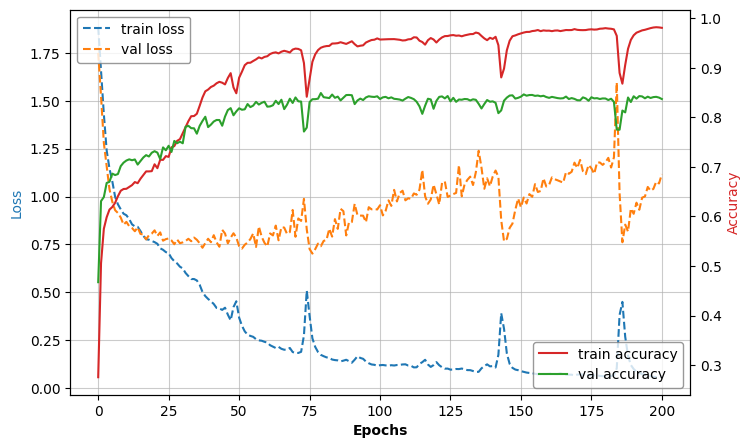

In [14]:
fig = plt.figure(figsize=(8,5))
ax1 = fig.add_subplot(111)
ax2 = ax1.twinx()
ax1.plot(fit.history['loss'],         ls='--', label='train loss',     color='tab:blue')
ax1.plot(fit.history['val_loss'],     ls='--', label='val loss',       color='tab:orange')
ax2.plot(fit.history['accuracy'],     ls='-',  label='train accuracy', color='tab:red')
ax2.plot(fit.history['val_accuracy'], ls='-',  label='val accuracy',   color='tab:green')
ax1.set_xlabel('Epochs', weight='bold')
ax1.set_ylabel('Loss', color='tab:blue')
ax2.set_ylabel('Accuracy', color='tab:red')
ax1.grid(True, which='both', alpha=0.66)
ax1.legend(loc='upper left', edgecolor='gray')
ax2.legend(loc='lower right', edgecolor='gray')
plt.savefig('figures/training_performance.png', dpi=600)
plt.show()

In [15]:
y_train_pred = model.predict(X_train[:15], verbose=0)
y_test_pred  = model.predict(X_test[:15], verbose=0)
print('Pred - train: {} | test: {}'.format(y_train_pred.shape, y_test_pred.shape))

Pred - train: (15, 512, 512, 7) | test: (15, 512, 512, 7)


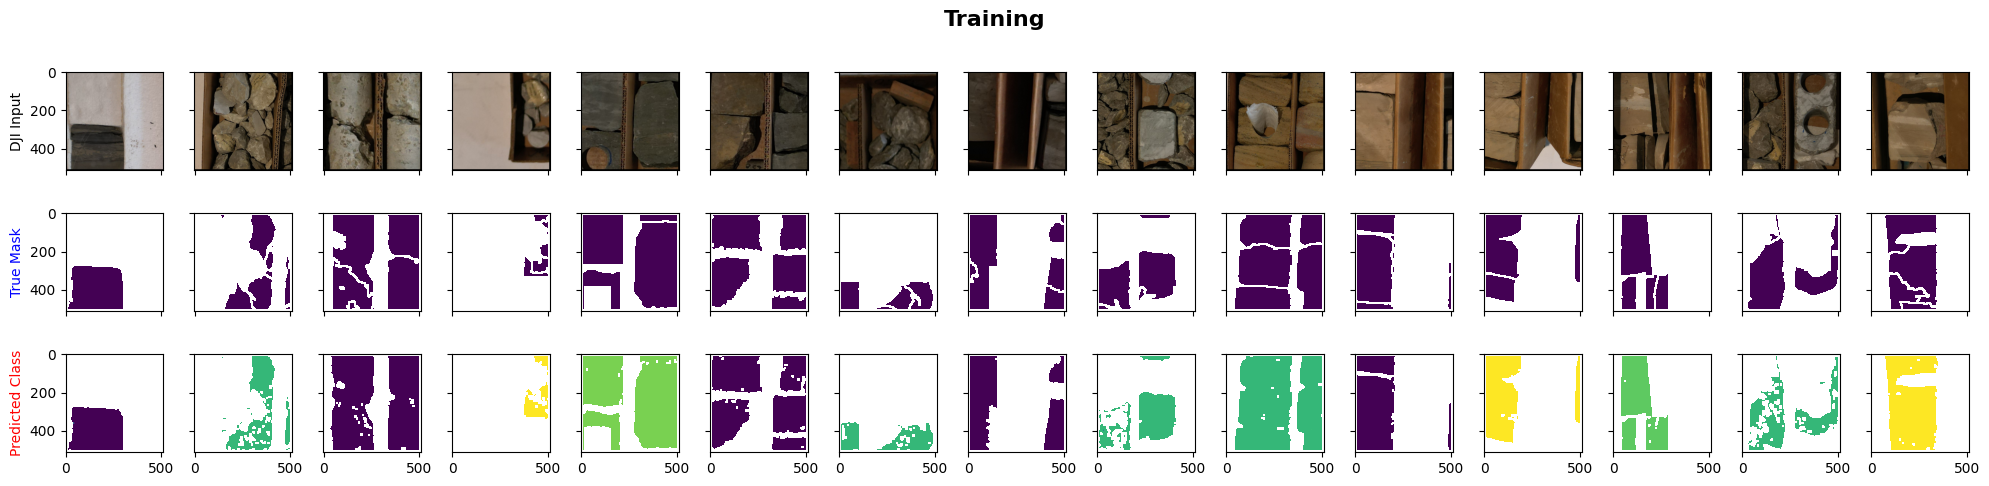

In [18]:
labels = ['DJI Input', 'True Mask', 'Predicted Class']
colors = ['black','blue','red']
fig, axs = plt.subplots(3, 15, figsize=(20,5), sharex=True, sharey=True)

for j in range(15):
    ax1, ax2, ax3 = axs[0,j], axs[1,j], axs[2,j]
    ax1.imshow(X_train[j])

    true = y_train_masked[j].argmax(-1)
    pred = y_train_pred[j].argmax(-1)

    dt = np.ma.masked_where(true==0, true)
    dp = np.ma.masked_where(pred==0, pred)

    ax2.imshow(dt)
    ax3.imshow(dp)

    [a.set_ylabel(labels[k], color=colors[k]) for k,a in enumerate([ax1,ax2,ax3])] if j==0 else None

fig.suptitle('Training', fontsize=16, weight='bold')
plt.tight_layout()
plt.savefig('figures/true_pred_train.png', dpi=600)
plt.show()

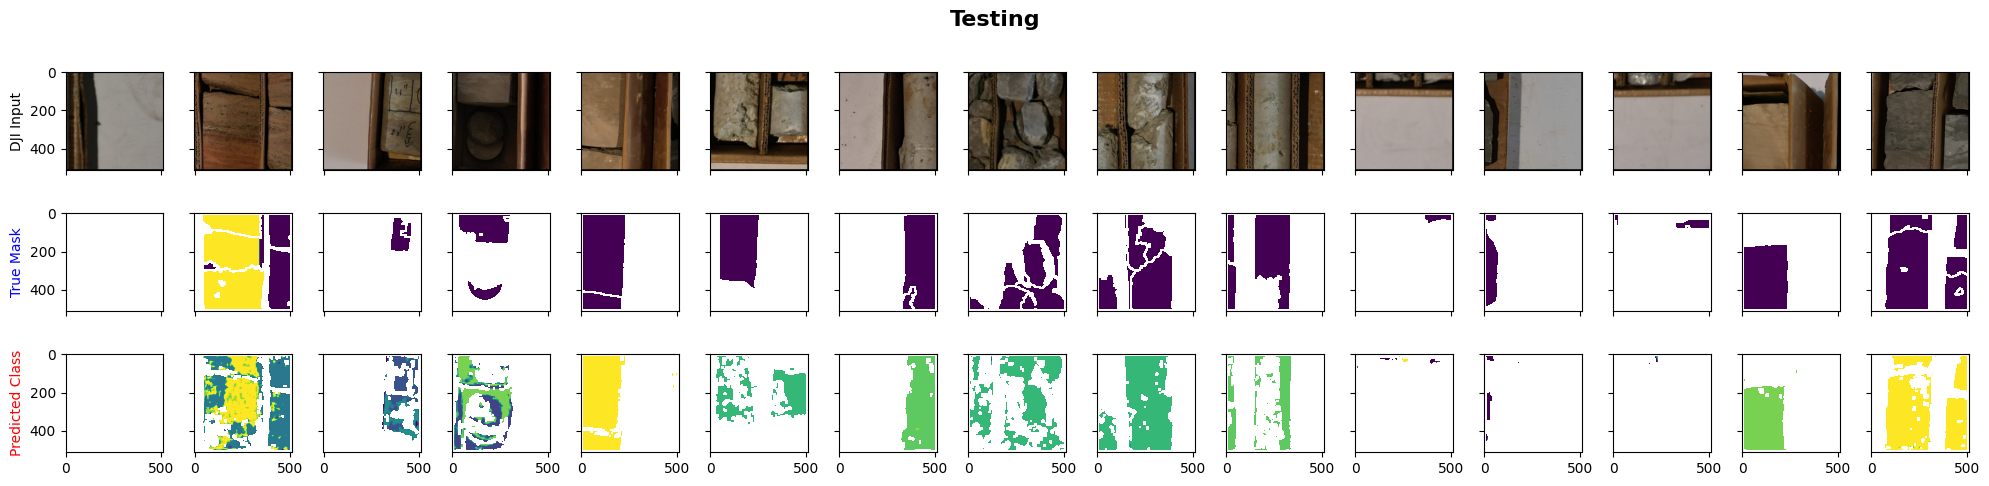

In [19]:
labels = ['DJI Input', 'True Mask', 'Predicted Class']
colors = ['black','blue','red']
fig, axs = plt.subplots(3, 15, figsize=(20,5), sharex=True, sharey=True)

for j in range(15):
    ax1, ax2, ax3 = axs[0,j], axs[1,j], axs[2,j]
    ax1.imshow(X_test[j])

    true = y_test_masked[j].argmax(-1)
    pred = y_test_pred[j].argmax(-1)

    dt = np.ma.masked_where(true==0, true)
    dp = np.ma.masked_where(pred==0, pred)

    ax2.imshow(dt)
    ax3.imshow(dp)

    [a.set_ylabel(labels[k], color=colors[k]) for k,a in enumerate([ax1,ax2,ax3])] if j==0 else None

fig.suptitle('Testing', fontsize=16, weight='bold')
plt.tight_layout()
plt.savefig('figures/true_pred_test.png', dpi=600)
plt.show()

***
# END